In [1]:
import pandas as pd
from pandas.io.formats.style import Styler
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['figure.dpi'] = 100

# Compare results from three runs of four-fold cross-validation

Evaluated models include

1) multi-annotator models with no extra layers
2) extra shared layer per group for a single attribute (gender, age, education, lgbq/sexual orientation)
3) randomly assigned groups, i.e. extra shared layers in the same proportions as groups for a single attribute (gender, education), but with random assignment


Dataset is a sample of the Kumar dataset with 5002 annotators

## Loading results dataset

In [3]:
df = pd.concat([
    pd.read_csv('../experiments/0.2-baseline/result.csv'),
    pd.read_csv('../experiments/1.1-age/result.csv'),
    pd.read_csv('../experiments/1.2-gender/result.csv'),
    pd.read_csv('../experiments/1.3-education/result.csv'),
    pd.read_csv('../experiments/1.4-lgbq/result.csv'),
    pd.read_csv('../experiments/2.1-age-random/result.csv'),
    pd.read_csv('../experiments/2.2-gender-random/result.csv'),
    pd.read_csv('../experiments/2.3-education-random/result.csv'),
    pd.read_csv('../experiments/2.4-lgbq-random/result.csv')   
]).rename(lambda c: c if not c.startswith('eval_') else c[5:], axis = 1)

df['attributes'] = df['attributes'].map({
        '[]': 'baseline',
        "['gender']": 'gender',
        "['age_range']": 'age',
        "['education']": 'education',
        "['lgbtq_status']": 'lgbq',
    })

majority_baseline_df = pd.read_csv('../../experiments/0.1-majority-baseline/result.csv') \
    .rename(lambda c: c if not c.startswith('eval_') else c[5:], axis = 1)
majority_baseline_df['attributes'] = 'majority baseline'

df = pd.concat([
    df,
    majority_baseline_df
]).reset_index(drop=True)

In [4]:
df.head()

,timestamp,loss,religion_important - Not too important - individual_0_precision,religion_important - Not too important - individual_0_recall,religion_important - Not too important - individual_0_f1-score,religion_important - Not too important - individual_0_support,religion_important - Not too important - individual_1_precision,religion_important - Not too important - individual_1_recall,religion_important - Not too important - individual_1_f1-score,religion_important - Not too important - individual_1_support,...,attributes,map_ids_to_attributes,setting,output_dir,while_train,do_stack_groups,do_random_assignment,group_layers_depth,random_seed,split
0,2023-05-18 14:17:53.858165,0.0,0.803314,0.808934,0.806114,1858,0.401349,0.392739,0.396997,606,...,baseline,[],K_FOLD,./models/custom_mt_model_multilabel,False,True,False,1,2803636207,0
1,2023-05-18 17:37:34.040978,0.0,0.807937,0.811371,0.809650,1882,0.422764,0.417335,0.420032,623,...,baseline,[],K_FOLD,./models/custom_mt_model_multilabel,False,True,False,1,2803636207,1
2,2023-05-18 21:00:48.039765,0.0,0.817697,0.824288,0.820979,1861,0.435233,0.424242,0.429668,594,...,baseline,[],K_FOLD,./models/custom_mt_model_multilabel,False,True,False,1,2803636207,2
3,2023-05-19 00:25:54.084455,0.0,0.821101,0.824885,0.822989,1953,0.424242,0.417910,0.421053,603,...,baseline,[],K_FOLD,./models/custom_mt_model_multilabel,False,True,False,1,2803636207,3
4,2023-05-19 03:52:51.881820,0.0,0.807292,0.814932,0.811094,1902,0.407407,0.395425,0.401327,612,...,baseline,[],K_FOLD,./models/custom_mt_model_multilabel,False,True,False,1,165043843,0


In [5]:
score_cols = ['individual_macro avg_f1-score', 'majority_macro avg_f1-score']
indiv_cols = ['individual_macro avg_f1-score']

In [6]:
df['attributes'].unique()

array(['baseline', 'age', 'gender', 'education', 'lgbq',
       'majority baseline'], dtype=object)

In [7]:
df[df['do_random_assignment'] == False].groupby('attributes').size()

attributes
age                  12
baseline             12
education            12
gender               12
lgbq                 12
majority baseline    12
dtype: int64

In [8]:
df[df['do_random_assignment'] == True].groupby('attributes').size()

attributes
age          12
education    12
gender       12
lgbq         12
dtype: int64

## Experiment Time

In [9]:
df[df['attributes'] != 'majority baseline'][['attributes','timestamp', 'random_seed', 'split']]

,attributes,timestamp,random_seed,split
0,baseline,2023-05-18 14:17:53.858165,2803636207,0
1,baseline,2023-05-18 17:37:34.040978,2803636207,1
2,baseline,2023-05-18 21:00:48.039765,2803636207,2
3,baseline,2023-05-19 00:25:54.084455,2803636207,3
4,baseline,2023-05-19 03:52:51.881820,165043843,0
...,...,...,...,...
103,lgbq,2023-05-19 23:21:24.199907,165043843,3
104,lgbq,2023-05-20 03:00:34.323622,2923262358,0
105,lgbq,2023-05-20 06:43:00.310028,2923262358,1
106,lgbq,2023-05-20 10:49:48.275316,2923262358,2


## Eval on individual labels

/home/matthias/.cache/pypoetry/virtualenvs/sociodemographic-softlabels-Sh-apy0E-py3.7/lib/python3.7/site-packages/seaborn/categorical.py:1682: UserWarning: You passed a edgecolor/edgecolors ([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)]) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  facecolor=colors, edgecolor=colors, label=self.label)


(0.0, 1.0)

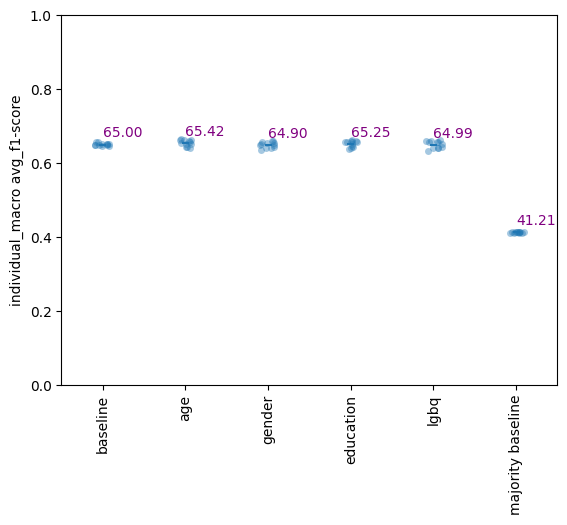

In [10]:
sns.stripplot(
    x="attributes", 
    y="individual_macro avg_f1-score",
    data=df[(df['do_random_assignment'] == False)],
    dodge=False, alpha=.4, zorder=1, legend=False
)

g = sns.pointplot(
    x="attributes", 
    y="individual_macro avg_f1-score", 
    data=df[(df['do_random_assignment'] == False)],
    join=False,
    markers='_', scale=.75, errorbar=None,
)

means_majority = df[(df['do_random_assignment'] == False)].groupby(['attributes', 'architecture'])['individual_macro avg_f1-score'].mean()

for i, (x, y) in enumerate(zip(means_majority.index, means_majority.values)):
    g.text(
        x = x[0], # x-coordinate position of data label
        y = y + 0.02, # if i % 2 == 0 else y - 0.01,
        s = f'{(y * 100):.2f}',
        color = 'purple'
    ) 

g.tick_params(axis='x', rotation=90)
g.xaxis.label.set_visible(False)
g.set_ylim((0.0,1.0))

/home/matthias/.cache/pypoetry/virtualenvs/sociodemographic-softlabels-Sh-apy0E-py3.7/lib/python3.7/site-packages/seaborn/categorical.py:1731: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/home/matthias/.cache/pypoetry/virtualenvs/sociodemographic-softlabels-Sh-apy0E-py3.7/lib/python3.7/site-packages/seaborn/categorical.py:1731: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725)) for an unfilled marker ('_').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)


(0.4, 0.7)

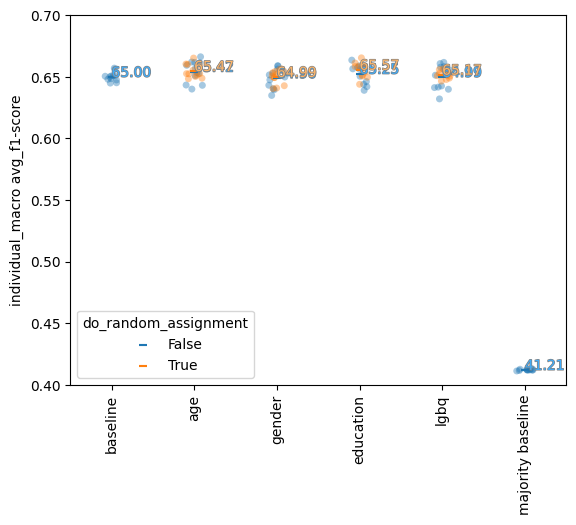

In [11]:
import matplotlib.patheffects

sns.stripplot(
    x="attributes", 
    y="individual_macro avg_f1-score",
    hue='do_random_assignment',
    data=df,#[df['architecture'] != 'single_task'],
    dodge=False, alpha=.4, zorder=1, legend=False
)

g = sns.pointplot(
    x="attributes", 
    y="individual_macro avg_f1-score",
    hue='do_random_assignment',
    data=df,#[df['architecture'] != 'single_task'],
    join=False,
    markers='_', scale=.75, errorbar=None,
)

means_individual = df.groupby(['attributes', 'do_random_assignment'])['individual_macro avg_f1-score'].mean()

for i, (x, y) in enumerate(zip(means_individual.index, means_individual.values)):
    txt = g.text(
        x = x[0], # x-coordinate position of data label
        y = y, # if i % 2 == 0 else y - 0.01,
        s = f'{(y * 100):.2f}',
        color = '#fdb66b' if x[1] else '#40adfb'
    )
    txt.set_path_effects([matplotlib.patheffects.withStroke(linewidth=1, foreground='grey')])


g.tick_params(axis='x', rotation=90)
g.xaxis.label.set_visible(False)
g.set_ylim((0.4,0.7))

### Result Tables

#### Results on individual labels for original assignment

In [12]:
table_mapping = {
    'individual_macro avg_f1-score': 'Macro F1',
    'attributes': 'Model'
}
overall_results_df = df.rename(columns=table_mapping)[df['do_random_assignment'] == False]
overall_results_df['Macro F1'] = overall_results_df['Macro F1'] * 100
overall_results_df = overall_results_df.groupby(['Model'])[["Macro F1"]].agg(['mean', 'std'])
overall_results_df.index = overall_results_df.index.map(lambda x: x.capitalize())
overall_results_df.index = overall_results_df.index.map(lambda x: 'Sexual orient.' if x == 'Lgbq' else x)
overall_results_df = overall_results_df.round(2)
overall_results_df = pd.DataFrame({'F1': overall_results_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1)})
overall_results_df = overall_results_df.reindex(['Majority baseline', 'Baseline', 'Gender', 'Age', 'Education', 'Sexual orient.'])
overall_results_df = overall_results_df.reset_index()
overall_results_df

,Model,F1
0,Majority baseline,41.21±0.05
1,Baseline,65.00±0.37
2,Gender,64.90±0.80
3,Age,65.42±0.85
4,Education,65.25±0.79
5,Sexual orient.,64.99±0.99


In [13]:
overall_results_df.to_latex('../tables/results/overall.tex', index=False)

#### Results on individual labels for random assignment

In [14]:
table_mapping = {
    'individual_macro avg_f1-score': 'Macro F1',
    'attributes': 'Model'
}
overall_random_df = df.rename(columns=table_mapping)[df['do_random_assignment'] == True]
overall_random_df['Macro F1'] = overall_random_df['Macro F1'] * 100
overall_random_df = overall_random_df.groupby(['Model'])[["Macro F1"]].agg(['mean', 'std'])
overall_random_df.index = overall_random_df.index.map(lambda x: x.capitalize())
overall_random_df = overall_random_df.round(2)
overall_random_df = overall_random_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1)
#overall_random_df = overall_random_df[['baseline', 'single-group', 'gender']]
#overall_random_df = overall_random_df.rename(columns={'gender': 'soc-dem.'})
#overall_random_df.columns.name = ''
#overall_random_df.columns = overall_random_df.columns.map(lambda col: col.capitalize())
overall_random_df

Model
Age          65.47±0.53
Education    65.57±0.59
Gender       64.99±0.57
Lgbq         65.17±0.30
dtype: object

## Eval on individual labels per group

In [15]:
def scores_per_group(
    df, 
    attribute, groups, 
    groups_mapping={}, 
    filter_single_task=True, 
    only_attribute=True
):
    if only_attribute:
        if attribute == 'age_range':
            attribute_value_name = 'age'
        elif attribute == 'lgbtq_status':
            attribute_value_name = 'lgbq'
        else:
            attribute_value_name = attribute

        SETTINGS = [
            'majority baseline',
            'baseline',
            attribute_value_name
        ]
    else:
        SETTINGS = [
            'majority baseline',
            'baseline',
            'age',
            'education',
            'gender',
            'lgbq'
        ]
    
    if not filter_single_task:
        SETTINGS += ['single-task']

    SCORE_COLS = [f'{attribute} - {g} - individual_macro avg_f1-score' for g in groups]

    if filter_single_task:
        df = df[df['attributes'] != 'single-task']
    
    if only_attribute:
        df = df[df['attributes'].isin(['majority baseline', 'baseline', 'single-group', attribute_value_name])]

    records = []
    for _, row in df[df['do_random_assignment'] == False][['attributes'] + SCORE_COLS].iterrows():

        for g in groups:
            records.append(
                {
                    'attributes': row['attributes'],
                    'F1-score':  row[f'{attribute} - {g} - individual_macro avg_f1-score'],
                    attribute: groups_mapping[g] if g in groups_mapping else g,
                    'layers': row['attributes']
                }
            )

    df_group_scores = pd.DataFrame.from_records(records)
    return df_group_scores

In [16]:
def plot_scores_per_group(df, attribute, groups, groups_mapping={}, filter_single_task=True, only_attribute=True):
    
    if only_attribute:
        if attribute == 'age_range':
            attribute_value_name = 'age'
        elif attribute == 'lgbtq_status':
            attribute_value_name = 'lgbq'
        else:
            attribute_value_name = attribute

        SETTINGS = [
            'baseline',
            attribute_value_name
        ]
    else:
        SETTINGS = [
            'baseline',
            'age',
            'education',
            'gender',
            'lgbq'
        ]
    
    if not filter_single_task:
        SETTINGS += ['single-task']

    SCORE_COLS = [f'{attribute} - {g} - individual_macro avg_f1-score' for g in groups]

    if filter_single_task:
        df = df[df['attributes'] != 'single-task']
    
    if only_attribute:
        df = df[df['attributes'].isin(['baseline', 'single-group', attribute_value_name])]

    records = []
    for _, row in df[df['do_random_assignment'] == False][['attributes'] + SCORE_COLS].iterrows():

        for g in groups:
            records.append(
                {
                    'attributes': row['attributes'],
                    'F1-score':  row[f'{attribute} - {g} - individual_macro avg_f1-score'],
                    attribute: groups_mapping[g] if g in groups_mapping else g,
                    'layers': row['attributes']
                }
            )

    df_group_scores = pd.DataFrame.from_records(records)

    model_means = df_group_scores.groupby(['attributes', attribute])['F1-score'].mean()


    g = g = sns.FacetGrid(df_group_scores, col=attribute, col_wrap=2, ylim=(0.4, 0.8))
    g.map(sns.stripplot, 'attributes', 'F1-score', 'layers', dodge=False, alpha=.4, zorder=1, legend=False, hue_order=SETTINGS, order=SETTINGS, palette='Set2')
    g.map(sns.pointplot, 'attributes', 'F1-score', 'layers', join=False, markers='o', scale=.5, errorbar=None, hue_order=SETTINGS, order=SETTINGS, palette='Set2')

    for group in df_group_scores[attribute].unique():
        ax = g.axes_dict[group]
        means_for_group = model_means.xs(group, level=1)

        no_extra_layers_mean = means_for_group.loc['baseline']
        ax.axhline(no_extra_layers_mean, linestyle='--', alpha=0.5, color='grey')

        for i, (x, y) in enumerate(zip(means_for_group.index, means_for_group.values)):

            is_max = means_for_group.idxmax() == x

            ax.text(
                x = x, # x-coordinate position of data label
                y = y + 0.01, # if i % 2 == 0 else y - 0.01,
                s = f'{(y * 100):.2f}',
                color = 'purple',
                fontsize=7,
                weight= 'demibold' if is_max else 'normal'
            )

    g.tick_params(axis='x', rotation=90)
    g.set_axis_labels(x_var='')

In [17]:
def plot_scores_random_per_group(df, attribute, groups, groups_mapping={}):

    SETTINGS = [
            False,
            True
    ]

    SCORE_COLS = [f'{attribute} - {g} - individual_macro avg_f1-score' for g in groups]

    if attribute == 'age_range':
        attribute_value_name = 'age'
    elif attribute == 'lgbtq_status':
        attribute_value_name = 'lgbq'
    else:
        attribute_value_name = attribute

    records = []
    for _, row in df[df['attributes'] == attribute_value_name][['do_random_assignment'] + SCORE_COLS].iterrows():
        for g in groups:
            records.append(
                {
                    'random': row['do_random_assignment'],
                    'F1-score':  row[f'{attribute} - {g} - individual_macro avg_f1-score'],
                    attribute_value_name: groups_mapping[g] if g in groups_mapping else g
                }
            )

    df_group_scores = pd.DataFrame.from_records(records)

    model_means = df_group_scores.groupby(['random', attribute_value_name])['F1-score'].mean()


    g = g = sns.FacetGrid(df_group_scores, col=attribute_value_name, col_wrap=2, ylim=(0.4, 0.8))
    g.map(sns.stripplot, 'random', 'F1-score', dodge=False, alpha=.4, zorder=1, legend=False, hue_order=SETTINGS, order=SETTINGS)
    g.map(sns.pointplot, 'random', 'F1-score',  join=False, markers='o', scale=.5, errorbar=None, hue_order=SETTINGS, order=SETTINGS)

    for group in df_group_scores[attribute_value_name].unique():
        ax = g.axes_dict[group]
        means_for_group = model_means.xs(group, level=1)

        for i, (x, y) in enumerate(zip(means_for_group.index, means_for_group.values)):
            ax.text(
                x = x, # x-coordinate position of data label
                y = y + 0.01, # if i % 2 == 0 else y - 0.01,
                s = f'{(y * 100):.2f}',
                color = 'purple',
                fontsize=7
            )

    g.tick_params(axis='x', rotation=90)
    g.set_axis_labels(x_var='')

In [18]:
def scores_random_per_group(df, attribute, groups, groups_mapping={}):

    SETTINGS = [
            False,
            True
    ]

    SCORE_COLS = [f'{attribute} - {g} - individual_macro avg_f1-score' for g in groups]

    if attribute == 'age_range':
        attribute_value_name = 'age'
    elif attribute == 'lgbtq_status':
        attribute_value_name = 'lgbq'
    else:
        attribute_value_name = attribute

    records = []
    for _, row in df[df['attributes'] == attribute_value_name][['do_random_assignment'] + SCORE_COLS].iterrows():
        for g in groups:
            records.append(
                {
                    'random': row['do_random_assignment'],
                    'F1-score':  row[f'{attribute} - {g} - individual_macro avg_f1-score'],
                    attribute_value_name: groups_mapping[g] if g in groups_mapping else g
                }
            )

    df_group_scores = pd.DataFrame.from_records(records)
    return df_group_scores

In [19]:
def plot_support_per_group(df, attribute, groups, groups_mapping={}):

    SUPPORT_COLS = [f'{attribute} - {g} - individual_macro avg_support' for g in groups]

    records = []
    for _, row in df[df['do_random_assignment'] == False][SUPPORT_COLS].iterrows():
        for g in groups:
            records.append(
                {
                    'support': row[f'{attribute} - {g} - individual_macro avg_support'],
                    attribute: groups_mapping[g] if g in groups_mapping else g
                }
            )

    df_group_support = pd.DataFrame.from_records(records)

    g = sns.barplot(
        x=attribute, 
        y="support",
        data=df_group_support,
        errorbar='sd',
        dodge=False, alpha=.4, zorder=1
    )

    for i in g.containers:
        g.bar_label(i,)

    g.tick_params(axis='x', rotation=90)

In [20]:
def support_per_group(df, attribute, groups, groups_mapping={}):

    SUPPORT_COLS = [f'{attribute} - {g} - individual_macro avg_support' for g in groups]

    records = []
    for _, row in df[df['do_random_assignment'] == False][SUPPORT_COLS].iterrows():
        for g in groups:
            records.append(
                {
                    'support': row[f'{attribute} - {g} - individual_macro avg_support'],
                    attribute: groups_mapping[g] if g in groups_mapping else g
                }
            )

    df_group_support = pd.DataFrame.from_records(records)

    return df_group_support

### Gender

#### Performance per gender

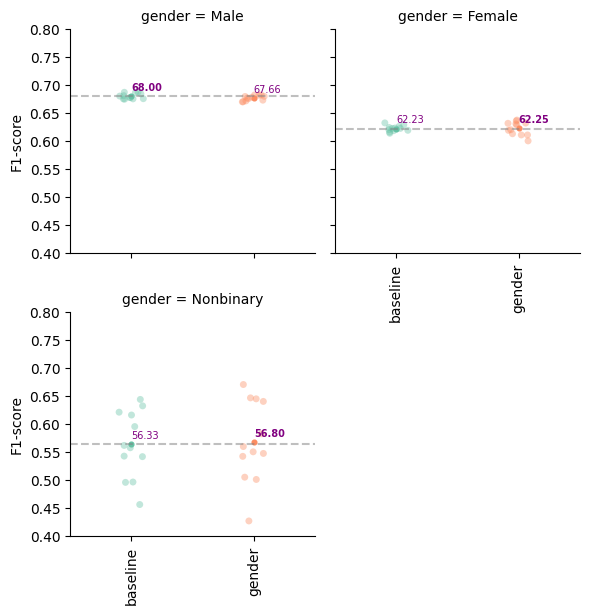

In [21]:
plot_scores_per_group(df, 'gender', ['Male','Female', 'Nonbinary'], filter_single_task=True)

#### Number of examples in test sets per gender

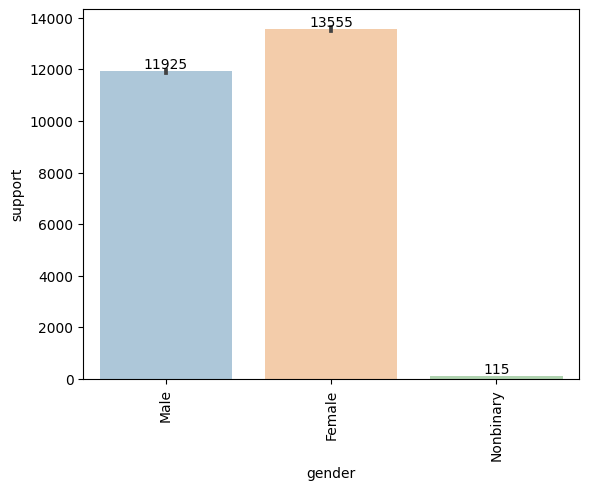

In [22]:
plot_support_per_group(df[df['attributes'] == 'gender'], 'gender', ['Male','Female', 'Nonbinary'])

#### Original vs random assignment per gender

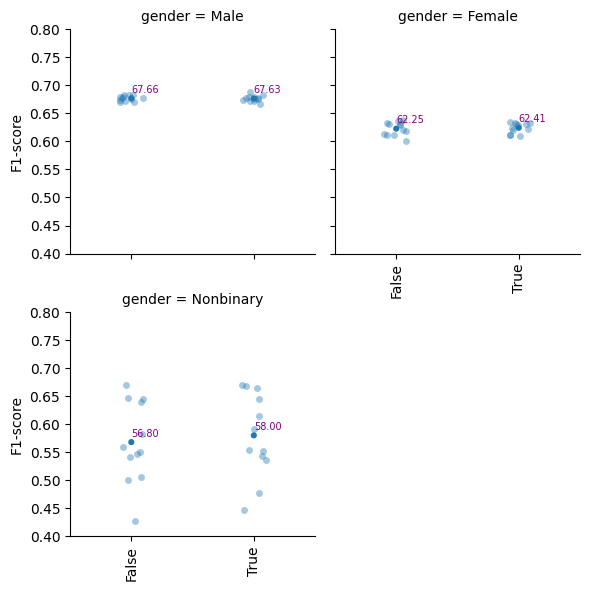

In [23]:
plot_scores_random_per_group(df, 'gender', ['Male','Female', 'Nonbinary'])

#### Tables

In [24]:
pd.__version__

'1.3.5'

In [29]:
gender_scores_df = scores_per_group(df, 'gender', ['Male','Female', 'Nonbinary', 'Prefer not to say', 'Other'], filter_single_task=True)
gender_scores_df = gender_scores_df.rename(columns={
    'attributes': 'Model', 
    'F1-score': 'Macro F1', 
    'gender': 'Gender'})\
    .groupby(['Gender', 'Model'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
gender_scores_df = gender_scores_df.round(2)
gender_scores_df = gender_scores_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
gender_scores_df = gender_scores_df[['majority baseline', 'baseline', 'gender']]
gender_scores_df = gender_scores_df.rename(columns={'gender': 'soc-dem.'})
gender_scores_df.columns.name = ''
gender_scores_df.columns = gender_scores_df.columns.map(lambda col: col.title())
gender_scores_df

,Majority Baseline,Baseline,Soc-Dem.
Gender,,,
Female,41.79±0.12,62.23±0.53,62.25±1.19
Male,40.53±0.11,68.00±0.49,67.66±0.46
Nonbinary,44.69±1.39,56.33±6.00,56.80±7.24
Other,45.50±4.69,48.56±10.78,50.53±14.63
Prefer not to say,41.05±0.36,64.54±1.13,65.05±1.52


In [26]:
gender_random_df = scores_random_per_group(df, 'gender', ['Male','Female', 'Nonbinary', 'Prefer not to say', 'Other'])
gender_random_df = gender_random_df.rename(columns={
    'random': 'Random', 
    'F1-score': 'Macro F1', 
    'gender': 'Gender'})
gender_random_df['Random'] = gender_random_df['Random'].apply(lambda x: 'Random' if x else 'Original')
gender_random_df = gender_random_df.groupby(['Gender', 'Random'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
gender_random_df = gender_random_df.round(2)
gender_random_df = gender_random_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
gender_random_df.columns.name = ''
gender_random_df.columns = gender_random_df.columns.map(lambda col: col.capitalize())
gender_random_df

,Original,Random
Gender,,
Female,62.25±1.19,62.41±0.92
Male,67.66±0.46,67.63±0.53
Nonbinary,56.80±7.24,58.00±7.49
Other,50.53±14.63,43.66±7.25
Prefer not to say,65.05±1.52,65.08±1.86


In [30]:
gender_df = gender_scores_df.join(gender_random_df[['Random']])
gender_df

,Majority Baseline,Baseline,Soc-Dem.,Random
Gender,,,,
Female,41.79±0.12,62.23±0.53,62.25±1.19,62.41±0.92
Male,40.53±0.11,68.00±0.49,67.66±0.46,67.63±0.53
Nonbinary,44.69±1.39,56.33±6.00,56.80±7.24,58.00±7.49
Other,45.50±4.69,48.56±10.78,50.53±14.63,43.66±7.25
Prefer not to say,41.05±0.36,64.54±1.13,65.05±1.52,65.08±1.86


In [31]:
columns = [c for c in gender_df.columns if c != 'Majority Baseline']
rows = ['Male','Female', 'Nonbinary']
Styler(gender_df.loc[rows][columns].reset_index()).hide_index().highlight_max(axis='columns', subset=['Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../../paper-grouplayer/tables/gender.tex', hrules=True)

In [32]:
Styler(gender_df.reset_index()).hide_index().highlight_max(axis='columns', subset=['Majority Baseline', 'Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../../paper-grouplayer/tables/full/gender.tex', hrules=True)

In [35]:
gender_support_df = support_per_group(df[df['attributes'] == 'gender'], 'gender', ['Male','Female', 'Nonbinary', 'Prefer not to say', 'Other'])
gender_support_df = gender_support_df.rename(columns={
    'gender': 'Gender'})\
    .groupby('Gender') \
    .agg(['mean', 'std', 'max', 'min'])
gender_support_df.columns = gender_support_df.columns.droplevel(0)
gender_support_df['Number of Annotations'] = gender_support_df.apply(lambda row: f'{row[0]:.0f}±{row[1]:.2f}', axis = 1)
gender_support_df = gender_support_df[['Number of Annotations', 'min', 'max']]
gender_support_df = gender_support_df.rename(columns=str.title)
gender_support_df

,Number Of Annotations,Min,Max
Gender,,,
Female,13555±86.44,13383.0,13664.0
Male,11925±61.65,11843.0,12062.0
Nonbinary,115±6.03,104.0,122.0
Other,5±1.95,2.0,8.0
Prefer not to say,2345±51.19,2281.0,2453.0


In [36]:
gender_support_df.to_latex('../paper-grouplayer/tables/support/gender.tex')

### Age

#### Performance per age group

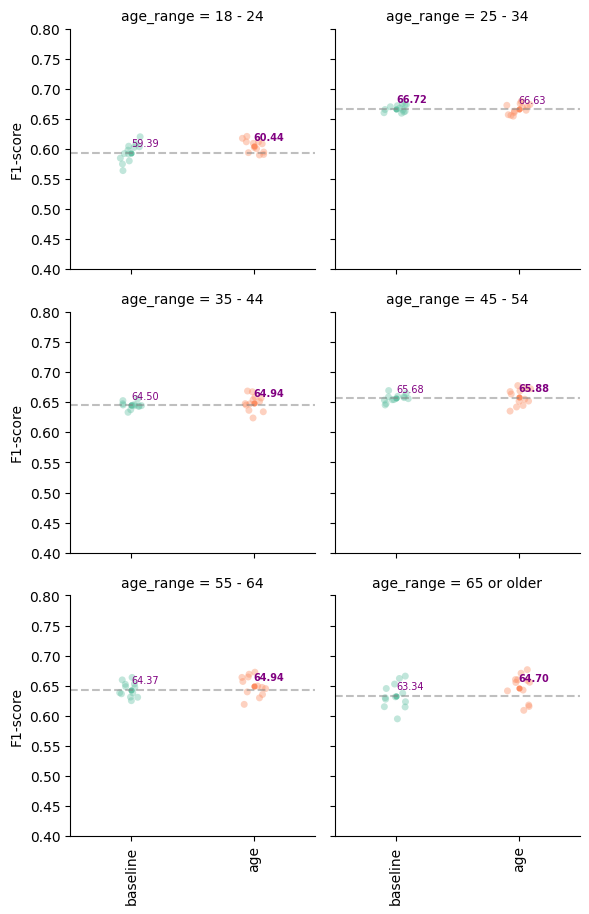

In [36]:
plot_scores_per_group(df, 'age_range', [
        '18 - 24', 
        '25 - 34', 
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older'
    ])

#### Number of examples in test sets per age group

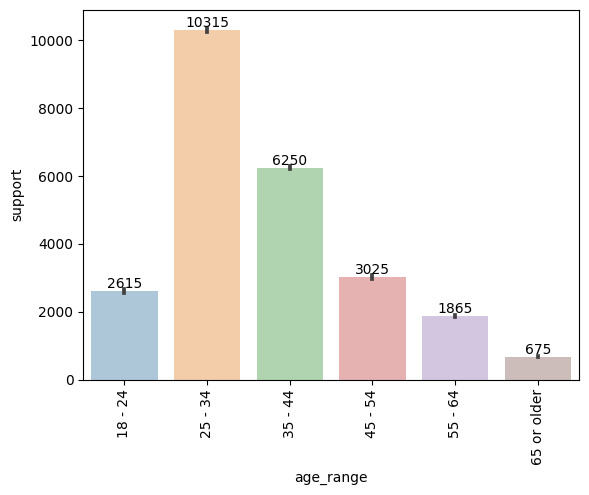

In [37]:
plot_support_per_group(df[df['attributes']  == 'age'], 'age_range', [
        '18 - 24', 
        '25 - 34', 
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older'
    ])

#### Original vs random assignment per age group

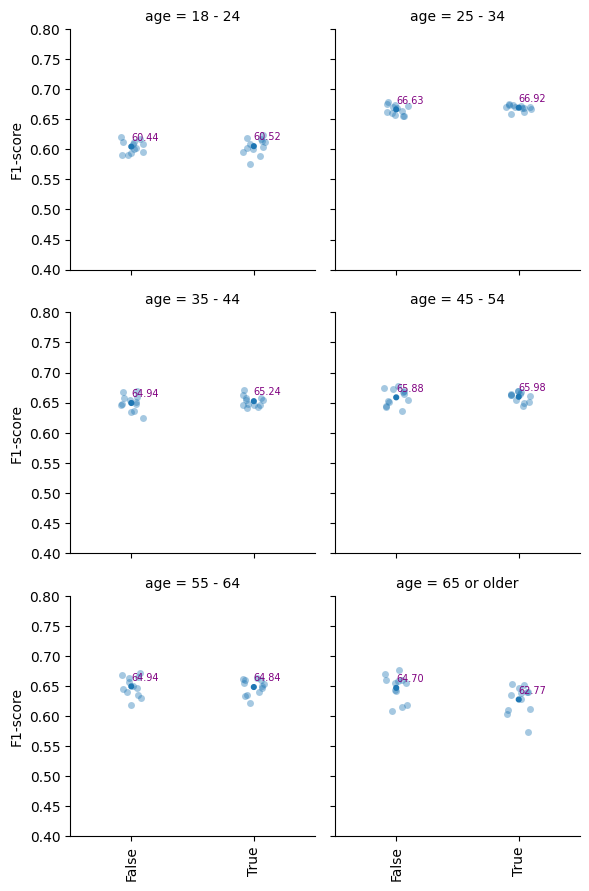

In [38]:
plot_scores_random_per_group(df, 'age_range', [
        '18 - 24', 
        '25 - 34', 
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older'
    ])

In [39]:
age_scores_df = scores_per_group(df, 'age_range', [
        '18 - 24', 
        '25 - 34',
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older',
        'Prefer not to say'
    ], filter_single_task=True)
age_scores_df = age_scores_df.rename(columns={
    'attributes': 'Model', 
    'F1-score': 'Macro F1', 
    'age_range': 'Age'})\
    .groupby(['Age', 'Model'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
age_scores_df = age_scores_df.round(2)
age_scores_df = age_scores_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
age_scores_df = age_scores_df[['majority baseline', 'baseline', 'age']]
age_scores_df = age_scores_df.rename(columns={'age': 'soc-dem.'})
age_scores_df.columns.name = ''
age_scores_df.columns = age_scores_df.columns.map(lambda col: col.title())
age_scores_df

,Majority Baseline,Baseline,Soc-Dem.
Age,,,
18 - 24,42.49±0.28,59.39±1.58,60.44±1.05
25 - 34,40.49±0.09,66.72±0.56,66.63±0.83
35 - 44,41.87±0.15,64.50±0.59,64.94±1.33
45 - 54,40.63±0.26,65.68±0.66,65.88±1.39
55 - 64,41.65±0.39,64.37±1.22,64.94±1.66
65 or older,41.46±0.54,63.34±2.07,64.70±2.21
Prefer not to say,41.37±0.32,63.99±1.32,65.24±1.18


In [40]:
age_random_df = scores_random_per_group(df, 'age_range', [
        '18 - 24', 
        '25 - 34', 
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older',
        'Prefer not to say'
    ])
age_random_df = age_random_df.rename(columns={
    'random': 'Random', 
    'F1-score': 'Macro F1', 
    'age': 'Age'})
age_random_df['Random'] = age_random_df['Random'].apply(lambda x: 'Random' if x else 'Original')
age_random_df = age_random_df.groupby(['Age', 'Random'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
age_random_df = age_random_df.round(2)
age_random_df = age_random_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
age_random_df.columns.name = ''
age_random_df.columns = age_random_df.columns.map(lambda col: col.title())
age_random_df


,Original,Random
Age,,
18 - 24,60.44±1.05,60.52±1.37
25 - 34,66.63±0.83,66.92±0.51
35 - 44,64.94±1.33,65.24±0.89
45 - 54,65.88±1.39,65.98±0.83
55 - 64,64.94±1.66,64.84±1.30
65 or older,64.70±2.21,62.77±2.39
Prefer not to say,65.24±1.18,64.73±1.33


In [41]:
age_df = age_scores_df.join(age_random_df[['Random']])
age_df

,Majority Baseline,Baseline,Soc-Dem.,Random
Age,,,,
18 - 24,42.49±0.28,59.39±1.58,60.44±1.05,60.52±1.37
25 - 34,40.49±0.09,66.72±0.56,66.63±0.83,66.92±0.51
35 - 44,41.87±0.15,64.50±0.59,64.94±1.33,65.24±0.89
45 - 54,40.63±0.26,65.68±0.66,65.88±1.39,65.98±0.83
55 - 64,41.65±0.39,64.37±1.22,64.94±1.66,64.84±1.30
65 or older,41.46±0.54,63.34±2.07,64.70±2.21,62.77±2.39
Prefer not to say,41.37±0.32,63.99±1.32,65.24±1.18,64.73±1.33


In [42]:
columns = [c for c in age_df.columns if c != 'Majority Baseline']
rows = age_df.index[:-1]
Styler(age_df.loc[rows][columns].reset_index()).hide_index().highlight_max(axis='columns', subset=['Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../../paper-grouplayer/tables/age.tex', hrules=True)

In [43]:
Styler(age_df.reset_index()).hide_index().highlight_max(axis='columns', subset=['Majority Baseline', 'Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../../paper-grouplayer/tables/full/age.tex', hrules=True)

In [44]:
age_support_df = support_per_group(df[df['attributes'] == 'age'], 'age_range', [
        '18 - 24', 
        '25 - 34', 
        '35 - 44', 
        '45 - 54', 
        '55 - 64', 
        '65 or older',
        'Prefer not to say'
    ])
age_support_df = age_support_df.rename(columns={
    'age_range': 'Age'})\
    .groupby('Age') \
    .agg(['mean', 'std', 'max', 'min'])
age_support_df.columns = age_support_df.columns.droplevel(0)
age_support_df['Number of Annotations'] = age_support_df.apply(lambda row: f'{row[0]:.0f}±{row[1]:.2f}', axis = 1)
age_support_df = age_support_df[['Number of Annotations', 'min', 'max']]
age_support_df = age_support_df.rename(columns=str.title)
age_support_df

,Number Of Annotations,Min,Max
Age,,,
18 - 24,2615±50.88,2521,2697
25 - 34,10315±61.45,10244,10457
35 - 44,6250±51.06,6179,6324
45 - 54,3025±47.23,2929,3083
55 - 64,1865±25.48,1831,1903
65 or older,675±19.31,643,704
Prefer not to say,3200±55.28,3131,3289


In [45]:
age_support_df.to_latex('../paper-grouplayer/tables/support/age.tex')

### Education

#### Performance per education level

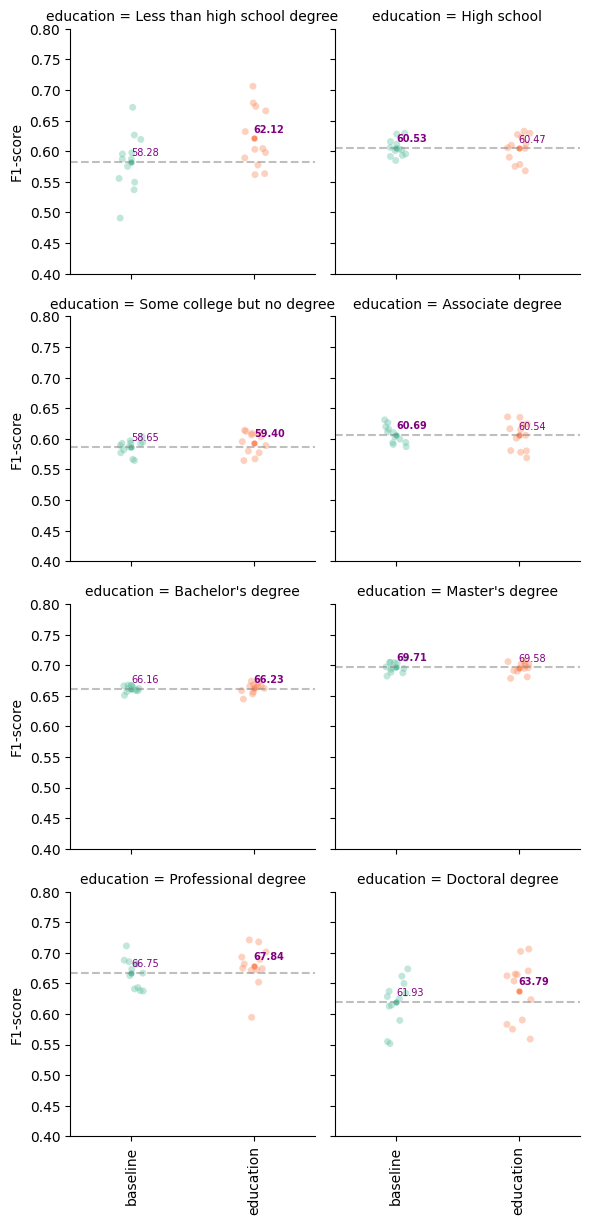

In [46]:
plot_scores_per_group(df, 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })

#### Number of examples in test sets per education level

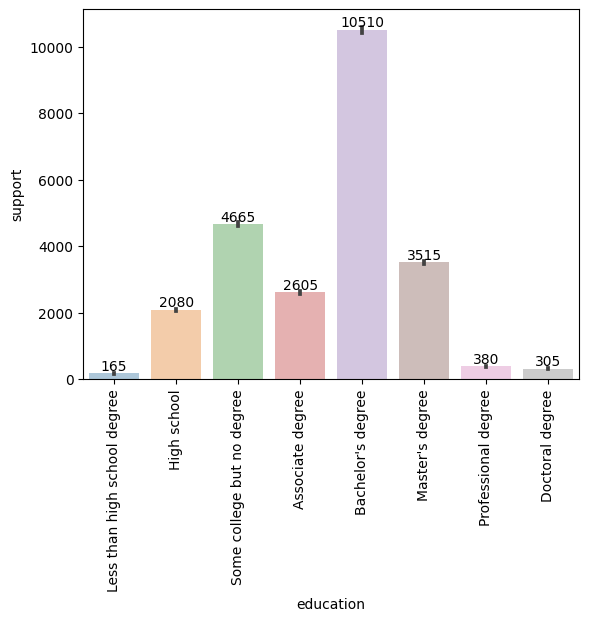

In [47]:
plot_support_per_group(df[df['attributes'] == 'education'], 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })

#### Original vs random group assignment per education level

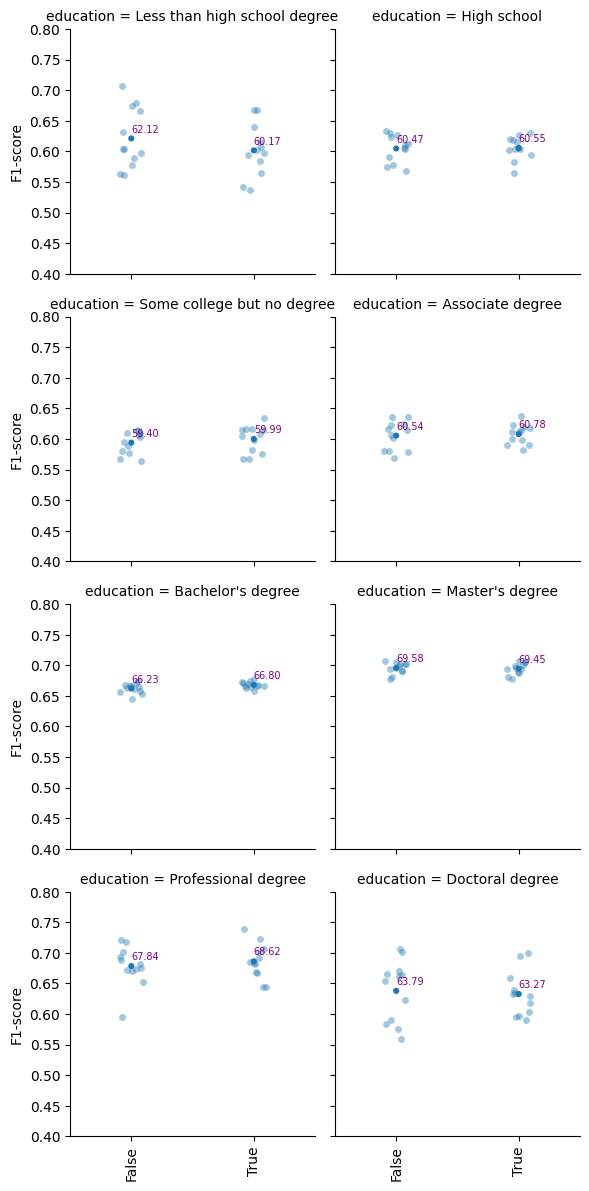

In [48]:
plot_scores_random_per_group(df, 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })

#### Education Tables

In [49]:
education_scores_df = scores_per_group(df, 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree',
        'Prefer not to say',
        'Other'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })
education_scores_df = education_scores_df.rename(columns={
    'attributes': 'Model', 
    'F1-score': 'Macro F1', 
    'education': 'Education'})\
    .groupby(['Education', 'Model'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
education_scores_df = education_scores_df.round(2)
education_scores_df = education_scores_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
education_scores_df = education_scores_df[['majority baseline', 'baseline', 'education']]
education_scores_df = education_scores_df.rename(columns={'education': 'soc-dem.'})
education_scores_df.columns.name = ''
education_scores_df.columns = education_scores_df.columns.map(lambda col: col.title())
rename_mapping = {'Less than high school degree': 'Below high school', 'Some college but no degree': 'College, no degree'}
education_scores_df.index = education_scores_df.index.map(lambda i: rename_mapping[i] if i in rename_mapping else i)
education_scores_df


,Majority Baseline,Baseline,Soc-Dem.
Education,,,
Associate degree,43.16±0.19,60.69±1.44,60.54±2.35
Bachelor's degree,40.38±0.10,66.16±0.51,66.23±0.82
Doctoral degree,43.34±0.94,61.93±3.82,63.79±5.03
High school,43.02±0.26,60.53±1.39,60.47±2.22
Below high school,43.10±1.44,58.28±4.68,62.12±4.90
Master's degree,37.55±0.32,69.71±0.86,69.58±0.93
Other,42.95±2.31,56.56±10.88,57.59±9.86
Prefer not to say,40.97±0.27,65.07±1.16,65.69±1.05
Professional degree,40.43±0.80,66.75±2.37,67.84±3.32


In [50]:
education_random_df = scores_random_per_group(df, 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree',
        'Prefer not to say',
        'Other'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })
education_random_df = education_random_df.rename(columns={
    'random': 'Random', 
    'F1-score': 'Macro F1', 
    'education': 'Education'})
education_random_df['Random'] = education_random_df['Random'].apply(lambda x: 'Random' if x else 'Original')
education_random_df = education_random_df.groupby(['Education', 'Random'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
education_random_df = education_random_df.round(2)
education_random_df = education_random_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
education_random_df.columns.name = ''
education_random_df.columns = education_random_df.columns.map(lambda col: col.title())
rename_mapping = {'Less than high school degree': 'Below high school', 'Some college but no degree': 'College, no degree'}
education_random_df.index = education_random_df.index.map(lambda i: rename_mapping[i] if i in rename_mapping else i)
education_random_df

,Original,Random
Education,,
Associate degree,60.54±2.35,60.78±1.62
Bachelor's degree,66.23±0.82,66.80±0.54
Doctoral degree,63.79±5.03,63.27±3.67
High school,60.47±2.22,60.55±1.87
Below high school,62.12±4.90,60.17±4.25
Master's degree,69.58±0.93,69.45±0.96
Other,57.59±9.86,57.71±12.28
Prefer not to say,65.69±1.05,65.74±1.09
Professional degree,67.84±3.32,68.62±2.84


In [51]:
education_df = education_scores_df.join(education_random_df[['Random']])
education_df

,Majority Baseline,Baseline,Soc-Dem.,Random
Education,,,,
Associate degree,43.16±0.19,60.69±1.44,60.54±2.35,60.78±1.62
Bachelor's degree,40.38±0.10,66.16±0.51,66.23±0.82,66.80±0.54
Doctoral degree,43.34±0.94,61.93±3.82,63.79±5.03,63.27±3.67
High school,43.02±0.26,60.53±1.39,60.47±2.22,60.55±1.87
Below high school,43.10±1.44,58.28±4.68,62.12±4.90,60.17±4.25
Master's degree,37.55±0.32,69.71±0.86,69.58±0.93,69.45±0.96
Other,42.95±2.31,56.56±10.88,57.59±9.86,57.71±12.28
Prefer not to say,40.97±0.27,65.07±1.16,65.69±1.05,65.74±1.09
Professional degree,40.43±0.80,66.75±2.37,67.84±3.32,68.62±2.84


In [52]:
columns = [c for c in education_df.columns if c != 'Majority Baseline']
rows = [i for i in education_df.index if i not in ['Other', 'Prefer not to say']]
Styler(education_df.loc[rows][columns].reset_index()).hide_index().highlight_max(axis='columns', subset=['Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../tables/education.tex', hrules=True)

In [53]:
Styler(education_df.reset_index()).hide_index().highlight_max(axis='columns', subset=['Majority Baseline', 'Baseline', 'Soc-Dem.', 'Random'], props='bfseries: ;').to_latex('../tables/full/education.tex', hrules=True)

In [54]:
education_support_df = support_per_group(df[df['attributes'] == 'education'], 'education', [
        'Less than high school degree',
        'High school graduate (high school diploma or equivalent including GED)',
        'Some college but no degree',
        'Associate degree in college (2-year)',
        "Bachelor's degree in college (4-year)",
        "Master's degree",
        'Professional degree (JD, MD)',
        'Doctoral degree',
        'Prefer not to say',
        'Other'
    ], groups_mapping= {
        'Associate degree in college (2-year)': 'Associate degree',
        "Bachelor's degree in college (4-year)":  "Bachelor's degree",
        'High school graduate (high school diploma or equivalent including GED)': 'High school',
        'Professional degree (JD, MD)': 'Professional degree'
    })

education_support_df = education_support_df.rename(columns={
    'education': 'Education'})\
    .groupby('Education') \
    .agg(['mean', 'std', 'max', 'min'])
education_support_df.columns = education_support_df.columns.droplevel(0)
education_support_df['Number of Annotations'] = education_support_df.apply(lambda row: f'{row[0]:.0f}±{row[1]:.2f}', axis = 1)
education_support_df = education_support_df[['Number of Annotations', 'min', 'max']]
education_support_df = education_support_df.rename(columns=str.title)
rename_mapping = {'Less than high school degree': 'Below high school', 'Some college but no degree': 'College, no degree'}
education_support_df.index = education_support_df.index.map(lambda i: rename_mapping[i] if i in rename_mapping else i)
education_support_df

,Number Of Annotations,Min,Max
Education,,,
Associate degree,2605±47.59,2516,2697
Bachelor's degree,10510±84.79,10348,10700
Doctoral degree,305±18.83,270,332
High school,2080±37.01,2015,2139
Below high school,165±11.17,144,184
Master's degree,3515±48.08,3425,3580
Other,30±3.44,25,36
Prefer not to say,3690±52.92,3603,3808
Professional degree,380±17.87,352,411


In [55]:
education_support_df.to_latex('../tables/support/education.tex')

### LGBQ Status

#### Performance per sexual orientation

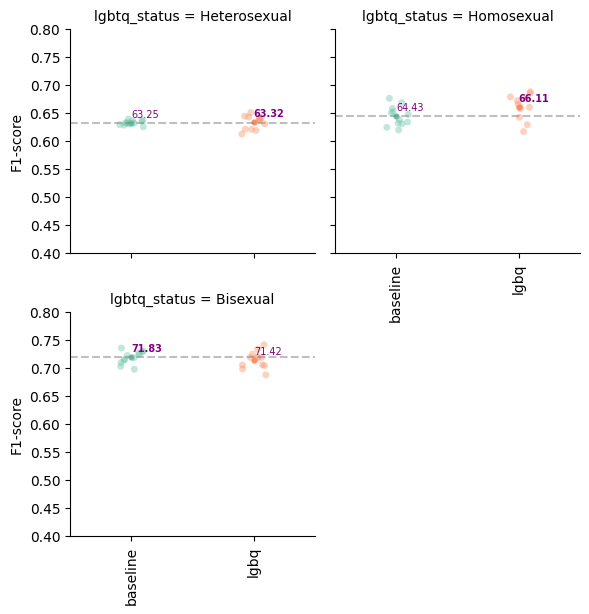

In [56]:
plot_scores_per_group(df, 'lgbtq_status',     [
        'Heterosexual', 
        'Homosexual', 
        'Bisexual'
    ], filter_single_task=True)

#### Number of examples in test sets per sexual orientation

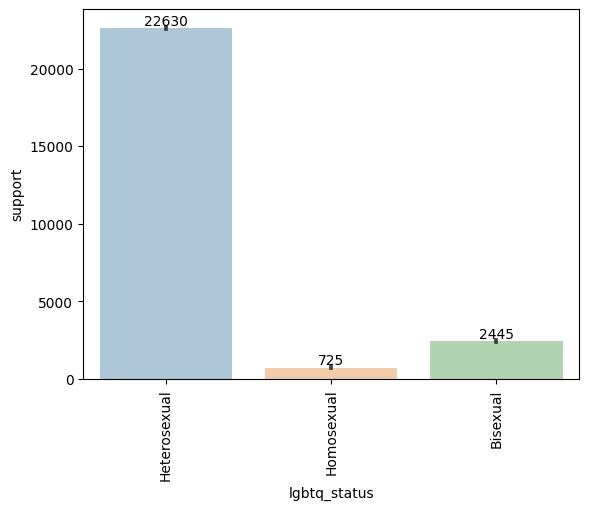

In [57]:
plot_support_per_group(df[df['attributes'] == 'lgbq'], 'lgbtq_status',     [
        'Heterosexual', 
        'Homosexual', 
        'Bisexual'
    ])

#### Original vs random assignment per sexual orientation

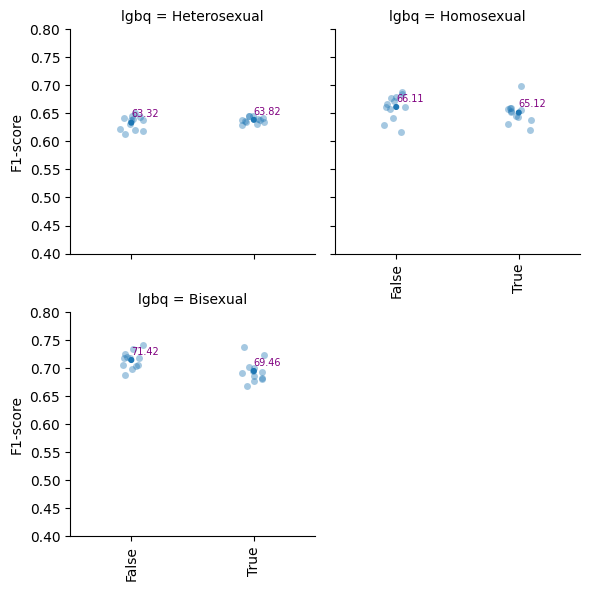

In [58]:
plot_scores_random_per_group(df, 'lgbtq_status', [
        'Heterosexual', 
        'Homosexual', 
        'Bisexual'
    ])

### LGBQ Tables

In [59]:
lgbq_scores_df = scores_per_group(df, 'lgbtq_status',     [
        'Heterosexual', 
        'Homosexual',
        'Bisexual',
        'Prefer not to say',
        'Other'
    ], filter_single_task=True)
lgbq_scores_df = lgbq_scores_df.rename(columns={
    'attributes': 'Model', 
    'F1-score': 'Macro F1', 
    'lgbtq_status': 'Sexuality'})\
    .groupby(['Sexuality', 'Model'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
lgbq_scores_df = lgbq_scores_df.round(2)
lgbq_scores_df = lgbq_scores_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
lgbq_scores_df = lgbq_scores_df[['majority baseline', 'baseline', 'lgbq']]
lgbq_scores_df = lgbq_scores_df.rename(columns={'lgbq': 'soc-dem.'})
lgbq_scores_df.columns.name = ''
lgbq_scores_df.columns = lgbq_scores_df.columns.map(lambda col: col.title())
lgbq_scores_df

,Majority Baseline,Baseline,Soc-Dem.
Sexuality,,,
Bisexual,34.69±0.50,71.83±1.14,71.42±1.51
Heterosexual,41.99±0.06,63.25±0.39,63.32±1.21
Homosexual,41.15±0.41,64.43±1.75,66.11±2.20
Other,43.53±0.78,57.55±3.79,60.57±4.51
Prefer not to say,39.12±0.24,67.80±1.56,67.27±1.52


In [60]:
lgbq_random_df = scores_random_per_group(df, 'lgbtq_status', [
        'Heterosexual', 
        'Homosexual', 
        'Bisexual',
        'Prefer not to say',
        'Other'
    ])
lgbq_random_df = lgbq_random_df.rename(columns={
    'random': 'Random', 
    'F1-score': 'Macro F1', 
    'lgbq': 'Sexuality'})
lgbq_random_df['Random'] = lgbq_random_df['Random'].apply(lambda x: 'Random' if x else 'Original')
lgbq_random_df = lgbq_random_df.groupby(['Sexuality', 'Random'])[["Macro F1"]]\
    .agg(['mean', 'std']) * 100
lgbq_random_df = lgbq_random_df.round(2)
lgbq_random_df = lgbq_random_df.apply(lambda row: f'{row[0]:.2f}±{row[1]:.2f}', axis = 1).unstack()
lgbq_random_df.columns.name = ''
lgbq_random_df.columns = lgbq_random_df.columns.map(lambda col: col.title())
lgbq_random_df

,Original,Random
Sexuality,,
Bisexual,71.42±1.51,69.46±1.95
Heterosexual,63.32±1.21,63.82±0.55
Homosexual,66.11±2.20,65.12±1.94
Other,60.57±4.51,58.69±4.72
Prefer not to say,67.27±1.52,67.46±1.11


In [61]:
lgbq_df = lgbq_scores_df.join(lgbq_random_df[['Random']])
lgbq_df

,Majority Baseline,Baseline,Soc-Dem.,Random
Sexuality,,,,
Bisexual,34.69±0.50,71.83±1.14,71.42±1.51,69.46±1.95
Heterosexual,41.99±0.06,63.25±0.39,63.32±1.21,63.82±0.55
Homosexual,41.15±0.41,64.43±1.75,66.11±2.20,65.12±1.94
Other,43.53±0.78,57.55±3.79,60.57±4.51,58.69±4.72
Prefer not to say,39.12±0.24,67.80±1.56,67.27±1.52,67.46±1.11


In [62]:
columns = [c for c in lgbq_df.columns if c != 'Majority Baseline']
rows = [i for i in lgbq_df.index if i not in ['Other', 'Prefer not to say']]
Styler(lgbq_df.loc[rows][columns].reset_index()).hide_index().highlight_max(axis='columns', subset=['Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../ tables/lgbq.tex', hrules=True)

In [63]:
Styler(lgbq_df.reset_index()).hide_index().highlight_max(axis='columns', subset=['Majority Baseline', 'Baseline', 'Soc-Dem.', 'Random'],props='bfseries: ;').to_latex('../tables/full/lgbq.tex', hrules=True)

In [64]:
lgbq_support_df = support_per_group(df[df['attributes'] == 'lgbq'], 'lgbtq_status',     [
        'Heterosexual', 
        'Homosexual', 
        'Bisexual',
        'Prefer not to say',
        'Other'
    ])

lgbq_support_df = lgbq_support_df.rename(columns={
    'lgbtq_status': 'Sexuality'})\
    .groupby('Sexuality') \
    .agg(['mean', 'std', 'max', 'min'])
lgbq_support_df.columns = lgbq_support_df.columns.droplevel(0)
lgbq_support_df['Number of Annotations'] = lgbq_support_df.apply(lambda row: f'{row[0]:.0f}±{row[1]:.2f}', axis = 1)
lgbq_support_df = lgbq_support_df[['Number of Annotations', 'min', 'max']]
lgbq_support_df = lgbq_support_df.rename(columns=str.title)
lgbq_support_df

,Number Of Annotations,Min,Max
Sexuality,,,
Bisexual,2445±39.26,2383,2501
Heterosexual,22630±63.00,22507,22726
Homosexual,725±26.57,670,759
Other,190±7.91,173,201
Prefer not to say,1955±35.39,1878,2009


In [65]:
lgbq_support_df.to_latex('../tables/support/lgbq.tex')